In [2]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.layers import Input, Dropout, Dense, GlobalAveragePooling2D
from keras.models import Sequential, Model
from keras.applications.resnet import ResNet50
from keras.applications import VGG16, DenseNet121, InceptionV3, VGG19, Xception, MobileNetV2, EfficientNetB0
from tensorboard import notebook
from tensorflow import keras
import numpy as np
import sys
sys.path.append("/root/autodl-tmp/training_tool/")
from training_tool import load_data, draw_curve, draw_matrix, TimeHistory
from tensorflow.keras.layers import ( Input, Conv2D, BatchNormalization, ReLU, MaxPooling2D, Concatenate, GlobalMaxPooling2D, Dropout,
    Dense, Lambda, Reshape, Activation, Multiply, Add, UpSampling2D, LayerNormalization, Flatten, AveragePooling2D )
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import tensorflow as tf

2024-03-18 09:58:58.471425: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


100%|██████████| 405/405 [00:00<00:00, 509.31it/s]


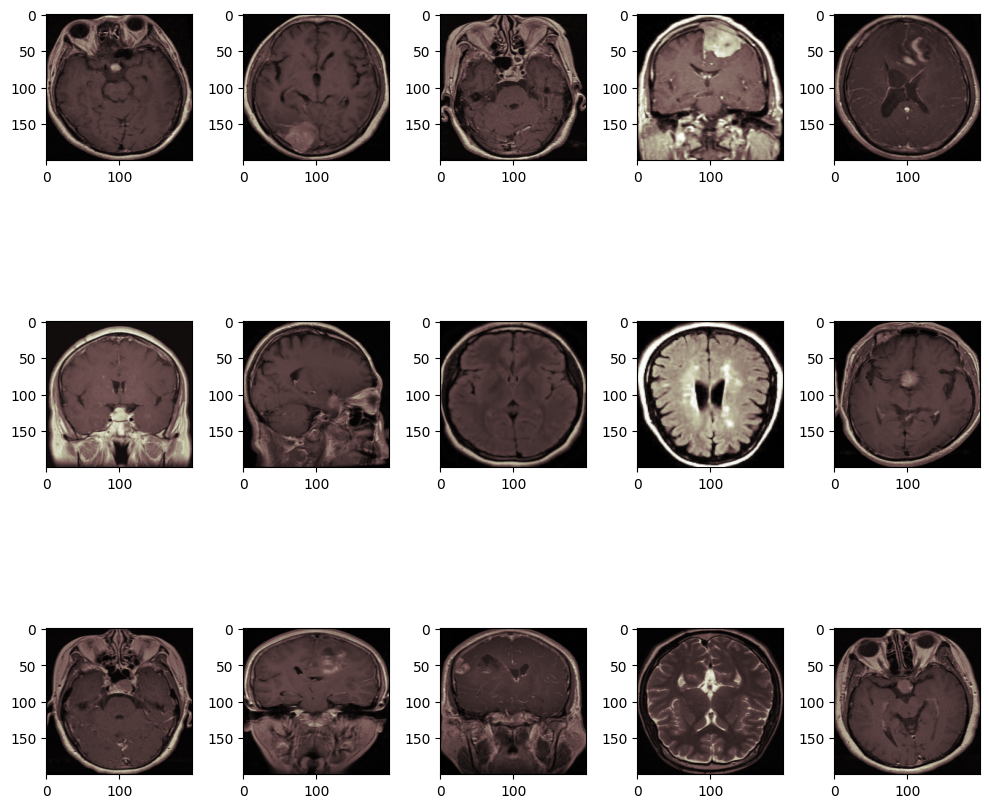

In [21]:
labels = ['glioma', 'meningioma', 'pituitary', 'notumor']
data_path = '/root/autodl-tmp/dataset/Br35H+SARTAJ+figshare/cropped'
image_size = 200
x_train, x_test, y_train, y_test = load_data(data_path, labels, image_size)

## ARM-Net

In [ ]:
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    BatchNormalization,
    ReLU,
    MaxPooling2D,
    Concatenate,
    GlobalMaxPooling2D,
    Dropout,
    Dense,
    Lambda,
    Reshape,
    Activation,
    Multiply,
    Add
)
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

def block(inputs, filters):
    a = Conv2D(filters, 3, padding='same')(inputs)
    a = BatchNormalization()(a)
    a = ReLU()(a)
    
    b = Conv2D(filters, 3, padding='same')(a)
    b = BatchNormalization()(b)
    b = ReLU()(b)
    
    c = Conv2D(filters, 3, padding='same')(b)
    c = BatchNormalization()(c)
    c = ReLU()(c)
    
    d = Conv2D(filters, 3, padding='same')(c)
    d = BatchNormalization()(d)
    d = ReLU()(d)
    
    mid = Concatenate()([a, b, c, d])
    mid = Conv2D(2 * filters, 1, padding='same')(mid)
    mid = BatchNormalization()(mid)
    mid = ReLU()(mid)
    
    x = Conv2D(filters * 2, 1)(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    x = Add()([mid, x])
    
    y = Conv2D(filters * 2, 1)(x)
    y = BatchNormalization()(y)
    y = ReLU()(y)
    
    return y

def Global_attention_block(C_A):
    x = Lambda(lambda x: K.mean(x, axis=-1, keepdims=True))(C_A)
    y = Lambda(lambda x: K.max(x, axis=-1, keepdims=True))(C_A)
    
    x = Concatenate()([x, y])
    x = Activation('relu')(x)
    x = Conv2D(1, 1, padding='same')(x)
    x = Activation('sigmoid')(x)
    S_A = Multiply()([x, C_A])
    
    return S_A

def self_attention(inp):
    shp = inp.shape
    a = Conv2D(shp[3] // 8, 1, padding='same')(inp)
    a = Activation('relu')(a)
    
    b = Conv2D(shp[3] // 8, 1, padding='same')(inp)
    b = Activation('relu')(b)
    
    c = Conv2D(shp[3] // 8, 1, padding='same')(inp)
    c = Activation('relu')(c)
    
    a = Reshape((shp[1] * shp[2], shp[3] // 8))(a)
    b = Reshape((shp[1] * shp[2], shp[3] // 8))(b)
    b = K.permute_dimensions(b, (0, 2, 1))
    c = Reshape((shp[1] * shp[2], shp[3] // 8))(c)
    inter = K.batch_dot(a, b)
    inter = Activation('softmax')(inter)
    out = K.batch_dot(inter, c)
    out = Reshape((shp[1], shp[2], shp[3] // 8))(out)
    out = Conv2D(shp[3], 1, padding='same')(out)
    out = Activation('relu')(out)
    
    return out

def channel_attention(inputs):
    shape = K.int_shape(inputs)
    x = MaxPooling2D(pool_size=(shape[1], shape[2]))(inputs)
    x = Conv2D(shape[3] // 8, 1, padding='same', kernel_initializer='he_normal', use_bias=False)(x)
    x = Activation('relu')(x)
    x = Conv2D(shape[3], 1, padding='same', kernel_initializer='he_normal', use_bias=False)(x)
    x = Activation('sigmoid')(x)
    x = Multiply()([x, inputs])
    
    return x

def load_model():
    K.clear_session()
    inputs = Input(shape=(200, 200, 3))
    x = Conv2D(16, 3, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(16, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D()(x)
    
    a1 = block(x, 32)
    x = MaxPooling2D()(a1)
    
    a2 = block(x, 64)
    x = MaxPooling2D()(a2)
    
    a3 = block(x, 128)
    a31 = self_attention(a3)
    a32 = Global_attention_block(a3)
    a3 = Add()([a31, a32])
    x = channel_attention(a3)
    
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(4, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=x)
    
    return model

Epoch 1/50


2024-03-17 21:10:57.646111: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200
2024-03-17 21:10:58.479921: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2024-03-17 21:10:58.479956: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2024-03-17 21:10:58.480131: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-03-17 21:10:58.977682: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


143/143 [==============================] - ETA: 0s - loss: 1.1508 - accuracy: 0.4914
Epoch 1: saving model to model-VGG16.h5
Epoch 1: 9.89 seconds
143/143 [==============================] - 10s 30ms/step - loss: 1.1508 - accuracy: 0.4914 - val_loss: 1.5986 - val_accuracy: 0.2150 - lr: 1.0000e-04
Epoch 2/50
142/143 [============================>.] - ETA: 0s - loss: 0.7483 - accuracy: 0.7207
Epoch 2: saving model to model-VGG16.h5
Epoch 2: 3.26 seconds
143/143 [==============================] - 3s 23ms/step - loss: 0.7474 - accuracy: 0.7210 - val_loss: 1.8317 - val_accuracy: 0.2902 - lr: 1.0000e-04
Epoch 3/50
143/143 [==============================] - ETA: 0s - loss: 0.4517 - accuracy: 0.8403
Epoch 3: saving model to model-VGG16.h5
Epoch 3: 3.34 seconds
143/143 [==============================] - 3s 23ms/step - loss: 0.4517 - accuracy: 0.8403 - val_loss: 1.3578 - val_accuracy: 0.5420 - lr: 1.0000e-04
Epoch 4/50
142/143 [============================>.] - ETA: 0s - loss: 0.3019 - accuracy: 

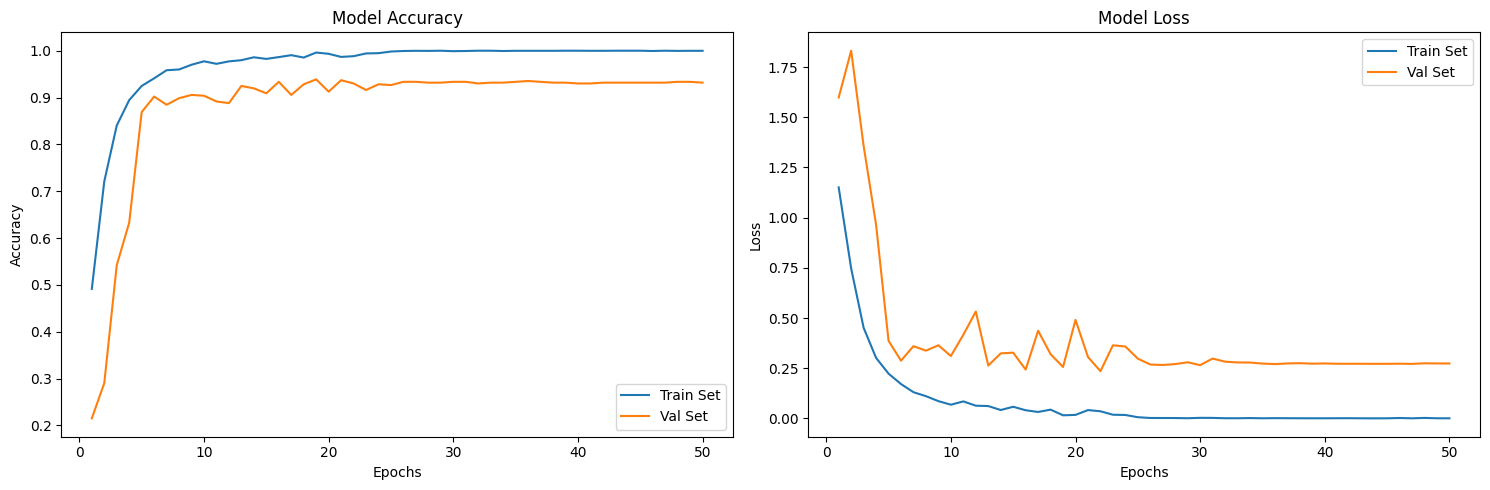

41/41 [==============================] - 0s 7ms/step - loss: 0.1962 - accuracy: 0.9603
Test Accuracy:  96.03
              precision    recall  f1-score   support

      glioma     0.9819    0.9067    0.9428       300
  meningioma     0.9209    0.9510    0.9357       306
   pituitary     0.9484    0.9800    0.9639       300
     notumor     0.9853    0.9926    0.9889       405

    accuracy                         0.9603      1311
   macro avg     0.9591    0.9576    0.9578      1311
weighted avg     0.9610    0.9603    0.9602      1311



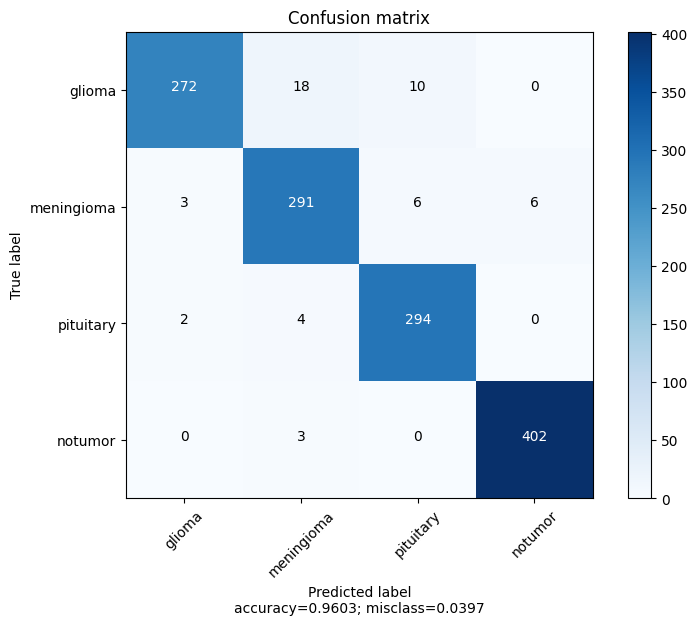

In [ ]:
model = load_model()
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='ARM-Net.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])

draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

## MFL-Net

In [ ]:
def mini_block(filters, x):
    conv = tf.keras.layers.Conv2D(filters , kernel_size=(3, 3),padding = "same")(x)
    bn = tf.keras.layers.BatchNormalization()(conv)
    act = tf.keras.layers.ReLU()(bn)
    return act

def double_mini_block(filters, x):
    t = mini_block(filters, x)
    t = mini_block(filters, t)
    return t

def MFL_Block(f,inp):
    block1 = mini_block(f,inp)
    block2 = double_mini_block(f,inp)
    c1 =  Concatenate()([block1, block2])
    conv = tf.keras.layers.Conv2D(f , kernel_size=(1, 1))(c1)
    block3 = mini_block(f,conv)
    block4 = mini_block(f,inp)
    c2 = Concatenate()([block3, block4])
    conv = tf.keras.layers.Conv2D(f, kernel_size=(1, 1))(c2)
    return conv

def MFL_Net():
    inp = tf.keras.layers.Input(shape=(200,200,3))
    b1 = mini_block(16,inp)
    pool = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(b1)
    p1 = MFL_Block(16,pool)
    pool = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(p1)
    p2 = MFL_Block(32,pool)
    pool = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(p2)
    p3 = MFL_Block(64,pool)
    pool = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(p3)
    p4 = MFL_Block(128,pool)
    globavg = tf.keras.layers.GlobalAveragePooling2D()(p4)
    drop = tf.keras.layers.Dropout(rate=0.5)(globavg)
    out = tf.keras.layers.Dense(4, activation='softmax')(drop)
    model = tf.keras.Model(inputs=inp, outputs=out)
    return model

Epoch 1/50
143/143 [==============================] - ETA: 0s - loss: 0.8176 - accuracy: 0.6663
Epoch 1: saving model to model-VGG16.h5
Epoch 1: 5.57 seconds
143/143 [==============================] - 6s 28ms/step - loss: 0.8176 - accuracy: 0.6663 - val_loss: 4.1377 - val_accuracy: 0.2150 - lr: 1.0000e-04
Epoch 2/50
141/143 [============================>.] - ETA: 0s - loss: 0.4987 - accuracy: 0.8077
Epoch 2: saving model to model-VGG16.h5
Epoch 2: 3.45 seconds
143/143 [==============================] - 3s 24ms/step - loss: 0.4975 - accuracy: 0.8082 - val_loss: 2.9024 - val_accuracy: 0.2850 - lr: 1.0000e-04
Epoch 3/50
142/143 [============================>.] - ETA: 0s - loss: 0.3759 - accuracy: 0.8664
Epoch 3: saving model to model-VGG16.h5
Epoch 3: 3.40 seconds
143/143 [==============================] - 3s 24ms/step - loss: 0.3757 - accuracy: 0.8665 - val_loss: 3.8324 - val_accuracy: 0.3409 - lr: 1.0000e-04
Epoch 4/50
142/143 [============================>.] - ETA: 0s - loss: 0.3283 - 

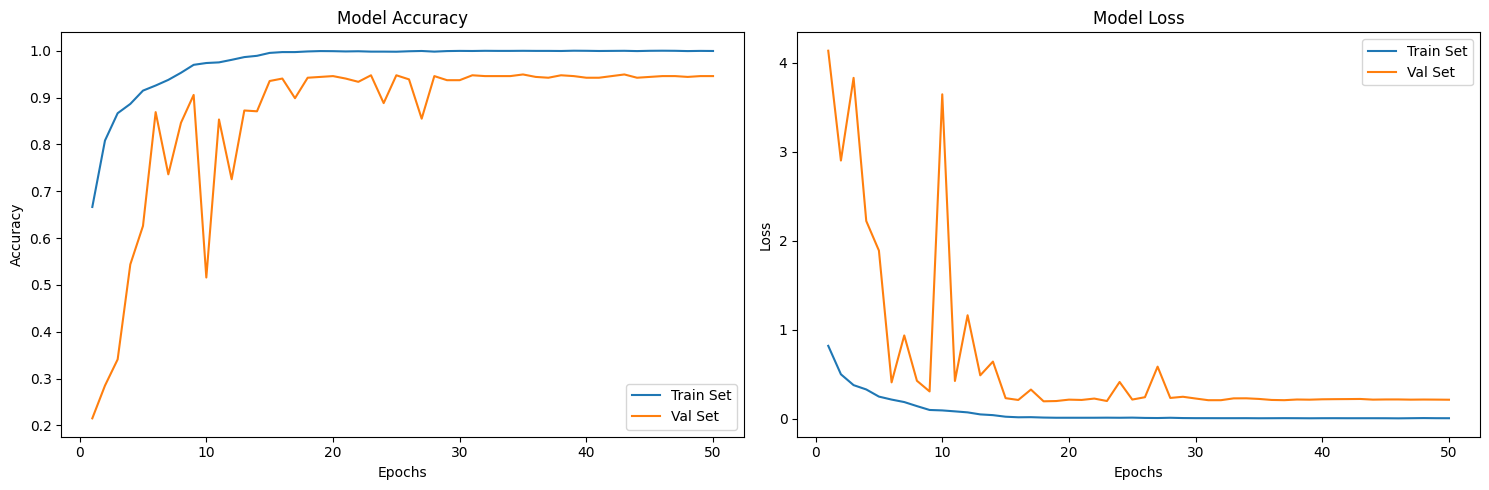

41/41 [==============================] - 0s 7ms/step - loss: 0.1477 - accuracy: 0.9558
Test Accuracy:  95.58
              precision    recall  f1-score   support

      glioma     0.9747    0.9000    0.9359       300
  meningioma     0.9016    0.9281    0.9147       306
   pituitary     0.9608    0.9800    0.9703       300
     notumor     0.9806    1.0000    0.9902       405

    accuracy                         0.9558      1311
   macro avg     0.9544    0.9520    0.9528      1311
weighted avg     0.9563    0.9558    0.9556      1311



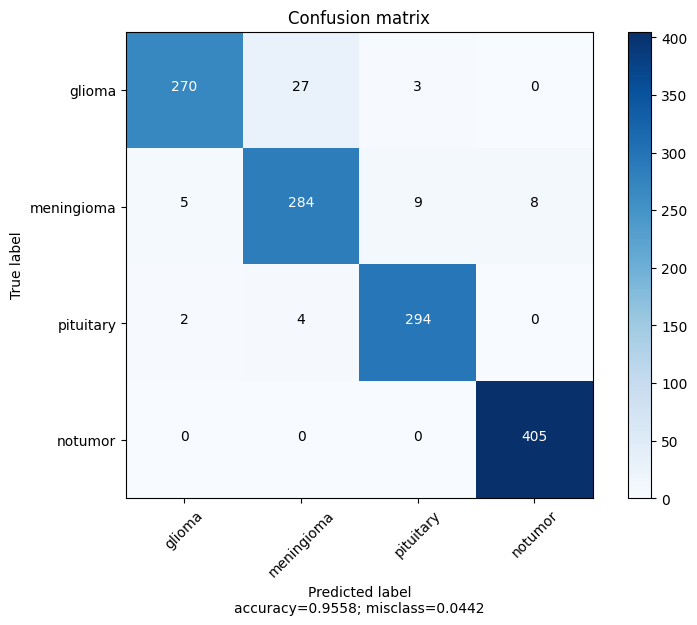

In [ ]:
model = MFL_Net()
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='MFL-Net.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])

draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

## CDANet

In [13]:
def PAB(inputs, channel_size):

    b, h, w, c = inputs.shape.as_list()

    x = Lambda(lambda x: K.mean(x, axis=-1, keepdims=True))(inputs)
    x = tf.reshape(x, [-1, 1, h*w])
    x = Activation('sigmoid')(x)
    x = K.batch_dot(x, tf.reshape(inputs, [-1, h*w, channel_size]))
    x = tf.reshape(x, [-1, 1, 1, channel_size])
    
    return x

def CAB(inputs, reduction=8):
    shape = K.int_shape(inputs)

    x = MaxPooling2D(pool_size=(shape[1], shape[2]))(inputs)
    x = Conv2D(shape[3] // reduction, 1, padding='same', kernel_initializer='he_normal', use_bias=False)(x)
    x = Activation('relu')(x)
    x = Conv2D(shape[3], 1, padding='same', kernel_initializer='he_normal', use_bias=False)(x)
    x = Activation('sigmoid')(x)
    
    return x
    
    
def CSDA(inputs,batch_size):

    f1 = []
    f2 = []
    half_size = inputs.shape[-1] // 2

    SPC_out = Lambda(lambda x: tf.split(x, num_or_size_splits=2, axis=-1))(inputs)
    

    f1 = SPC_out[0]
    f2 = SPC_out[1]

    x = Concatenate()([CAB(f1), PAB(f1, half_size)])
    x = Conv2D(half_size, 1, padding='same')(x)
    x = Activation('sigmoid')(x)
    f1 = Multiply()([x, f1])

    y = Concatenate()([CAB(f2), PAB(f2, half_size)])
    y = Conv2D(half_size, 1, padding='same')(y)
    y = Activation('sigmoid')(y)
    f2 = Multiply()([y, f2])

    outputs = Concatenate()([f1, f2])
        
    return outputs
    
    
        

def load_model():
    K.clear_session()
    inputs = Input(shape=(200, 200, 3))
    shape = K.int_shape(inputs)

    net = DenseNet121(weights=None, include_top=False, input_shape=(200, 200, 3))
    x = net.output
    
    x = CSDA(x, 36)
    
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(4, activation='softmax')(x)
    model = Model(inputs= net.input, outputs=x)
    
    return model


Epoch 1/50
143/143 [==============================] - ETA: 0s - loss: 0.7186 - accuracy: 0.7134
Epoch 1: saving model to model-VGG16.h5
Epoch 1: 19.17 seconds
143/143 [==============================] - 19s 88ms/step - loss: 0.7186 - accuracy: 0.7134 - val_loss: 2.2918 - val_accuracy: 0.2587 - lr: 1.0000e-04
Epoch 2/50
143/143 [==============================] - ETA: 0s - loss: 0.3727 - accuracy: 0.8636
Epoch 2: saving model to model-VGG16.h5
Epoch 2: 10.97 seconds
143/143 [==============================] - 11s 77ms/step - loss: 0.3727 - accuracy: 0.8636 - val_loss: 4.5436 - val_accuracy: 0.2587 - lr: 1.0000e-04
Epoch 3/50
143/143 [==============================] - ETA: 0s - loss: 0.2717 - accuracy: 0.9051
Epoch 3: saving model to model-VGG16.h5
Epoch 3: 11.32 seconds
143/143 [==============================] - 11s 79ms/step - loss: 0.2717 - accuracy: 0.9051 - val_loss: 2.8975 - val_accuracy: 0.3846 - lr: 1.0000e-04
Epoch 4/50
142/143 [============================>.] - ETA: 0s - loss: 0.2

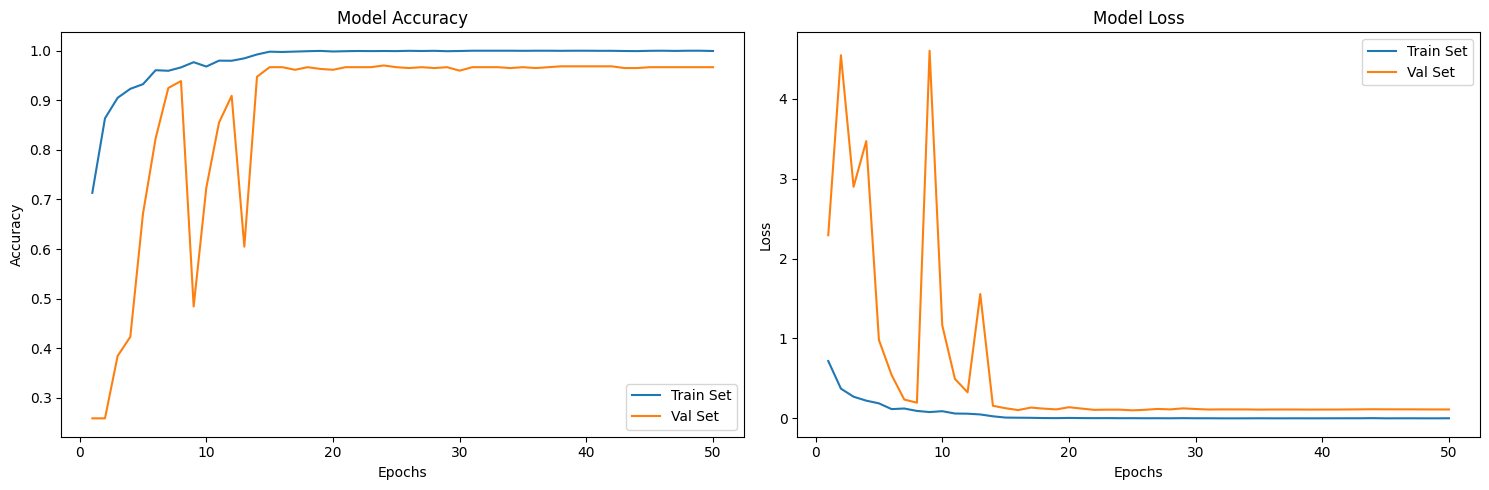

41/41 [==============================] - 1s 19ms/step - loss: 0.0763 - accuracy: 0.9756
Test Accuracy:  97.56
              precision    recall  f1-score   support

      glioma     0.9863    0.9633    0.9747       300
  meningioma     0.9511    0.9542    0.9527       306
   pituitary     0.9801    0.9833    0.9817       300
     notumor     0.9829    0.9951    0.9890       405

    accuracy                         0.9756      1311
   macro avg     0.9751    0.9740    0.9745      1311
weighted avg     0.9756    0.9756    0.9756      1311



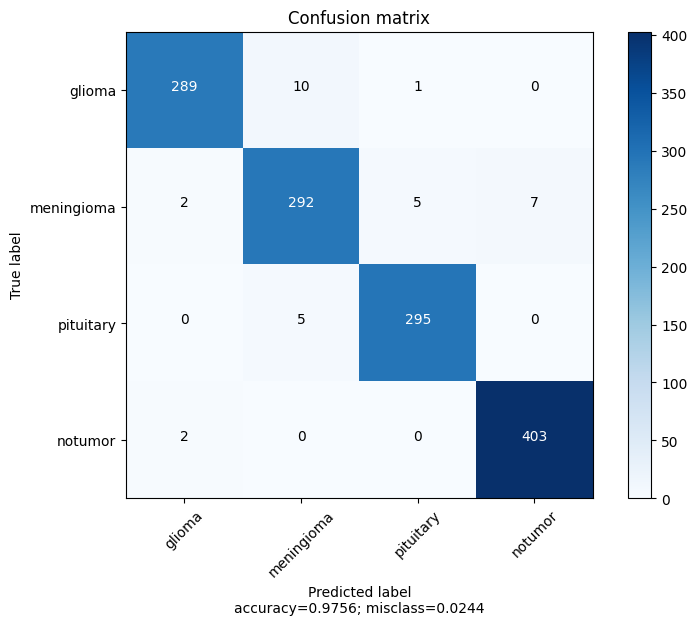

In [15]:
model = load_model()
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='CDANet.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])

draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

## CapsNet

100%|██████████| 405/405 [00:00<00:00, 541.97it/s]


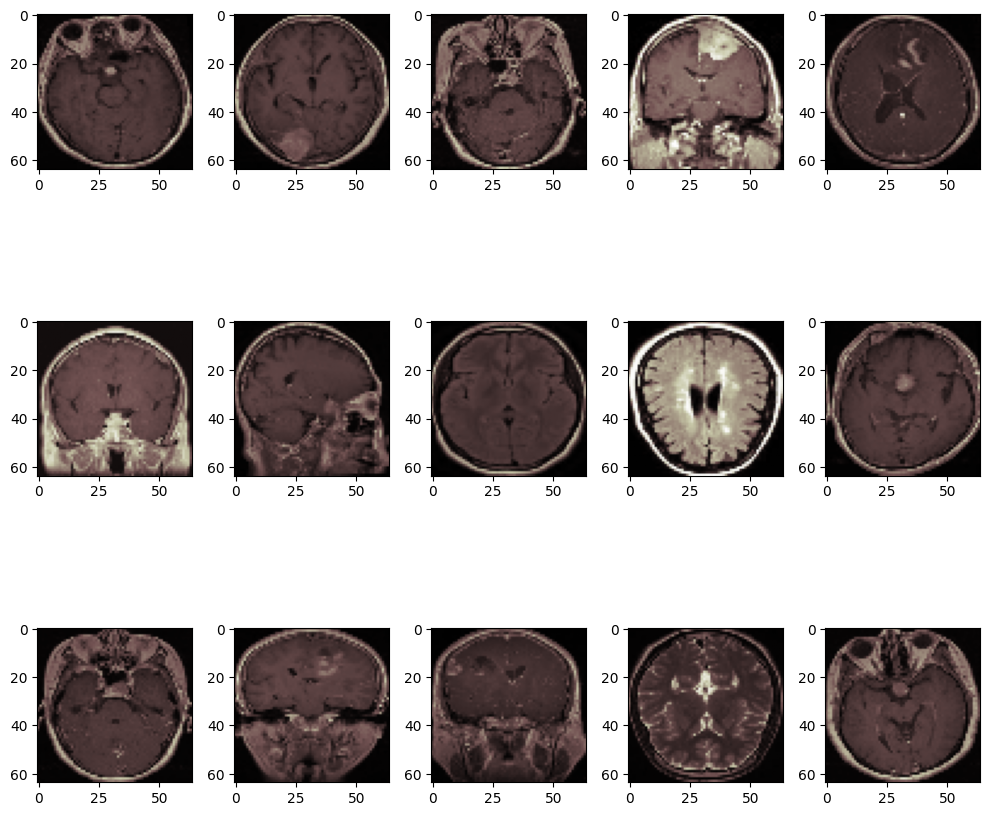

In [16]:
labels = ['glioma', 'meningioma', 'pituitary', 'notumor']
data_path = '/root/autodl-tmp/dataset/Br35H+SARTAJ+figshare/cropped'
image_size = 64
x_train, x_test, y_train, y_test = load_data(data_path, labels, image_size)

In [19]:
sys.path.append("/root/autodl-tmp/model/CapsuleNet/capsnet-keras/")
from capsulelayers import CapsuleLayer, PrimaryCap, Length, Mask
from keras import models, layers
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    BatchNormalization,
    ReLU,
    MaxPooling2D,
    Concatenate,
    GlobalMaxPooling2D,
    Dropout,
    Dense,
    Lambda,
    Reshape,
    Activation,
    Multiply,
    Add
)
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K


def load_model():
    K.clear_session()
    inputs = Input(shape=(64, 64, 3))

    conv1 = layers.Conv2D(64, (9, 9), activation='relu', name="FirstLayer")(inputs)

    primaryCaps = PrimaryCap(inputs=conv1, dim_capsule=8, n_channels=32, kernel_size=9, strides=2, padding='valid')
    
    capLayer2 = CapsuleLayer(num_capsule=3, dim_capsule=16, routings=2, name="ThirdLayer")(primaryCaps)
    
    x = GlobalAveragePooling2D()(capLayer2)
    x = Dropout(0.5)(x)
    x = Dense(4, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=x)
    
    return model

Epoch 1/50
143/143 [==============================] - ETA: 0s - loss: 1.2017 - accuracy: 0.4625


Epoch 1: saving model to model-VGG16.h5
Epoch 1: 5.43 seconds
143/143 [==============================] - 5s 32ms/step - loss: 1.2017 - accuracy: 0.4625 - val_loss: 1.0360 - val_accuracy: 0.6521 - lr: 1.0000e-04
Epoch 2/50
143/143 [==============================] - ETA: 0s - loss: 0.9932 - accuracy: 0.6658
Epoch 2: saving model to model-VGG16.h5
Epoch 2: 4.30 seconds
143/143 [==============================] - 4s 30ms/step - loss: 0.9932 - accuracy: 0.6658 - val_loss: 0.9264 - val_accuracy: 0.7098 - lr: 1.0000e-04
Epoch 3/50
143/143 [==============================] - ETA: 0s - loss: 0.9283 - accuracy: 0.7095
Epoch 3: saving model to model-VGG16.h5
Epoch 3: 4.26 seconds
143/143 [==============================] - 4s 30ms/step - loss: 0.9283 - accuracy: 0.7095 - val_loss: 0.8972 - val_accuracy: 0.7308 - lr: 1.0000e-04
Epoch 4/50
142/143 [============================>.] - ETA: 0s - loss: 0.8851 - accuracy: 0.7420
Epoch 4: saving model to model-VGG16.h5
Epoch 4: 4.27 seconds
143/143 [=======

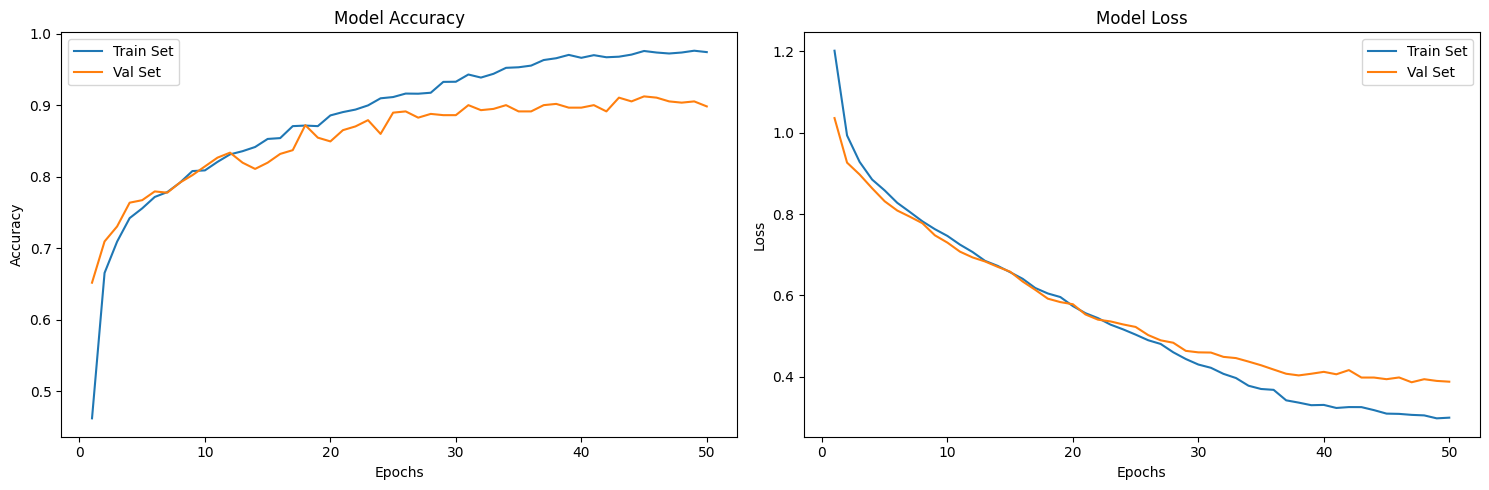

41/41 [==============================] - 0s 11ms/step - loss: 0.3528 - accuracy: 0.9176
Test Accuracy:  91.76
              precision    recall  f1-score   support

      glioma     0.8874    0.8933    0.8904       300
  meningioma     0.9057    0.7843    0.8406       306
   pituitary     0.9327    0.9700    0.9510       300
     notumor     0.9352    0.9975    0.9654       405

    accuracy                         0.9176      1311
   macro avg     0.9152    0.9113    0.9118      1311
weighted avg     0.9168    0.9176    0.9158      1311



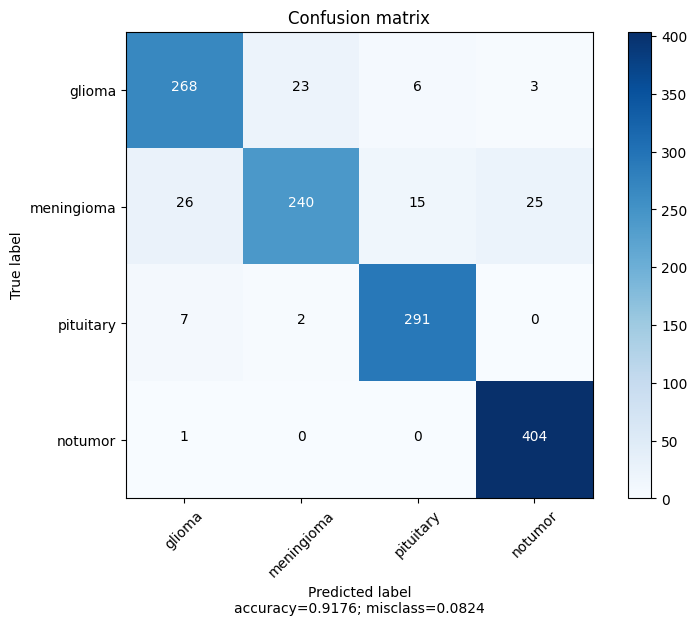

In [20]:
model = load_model()
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='CapsNet.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])

draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

## NeuroNet19

100%|██████████| 405/405 [00:00<00:00, 544.06it/s]


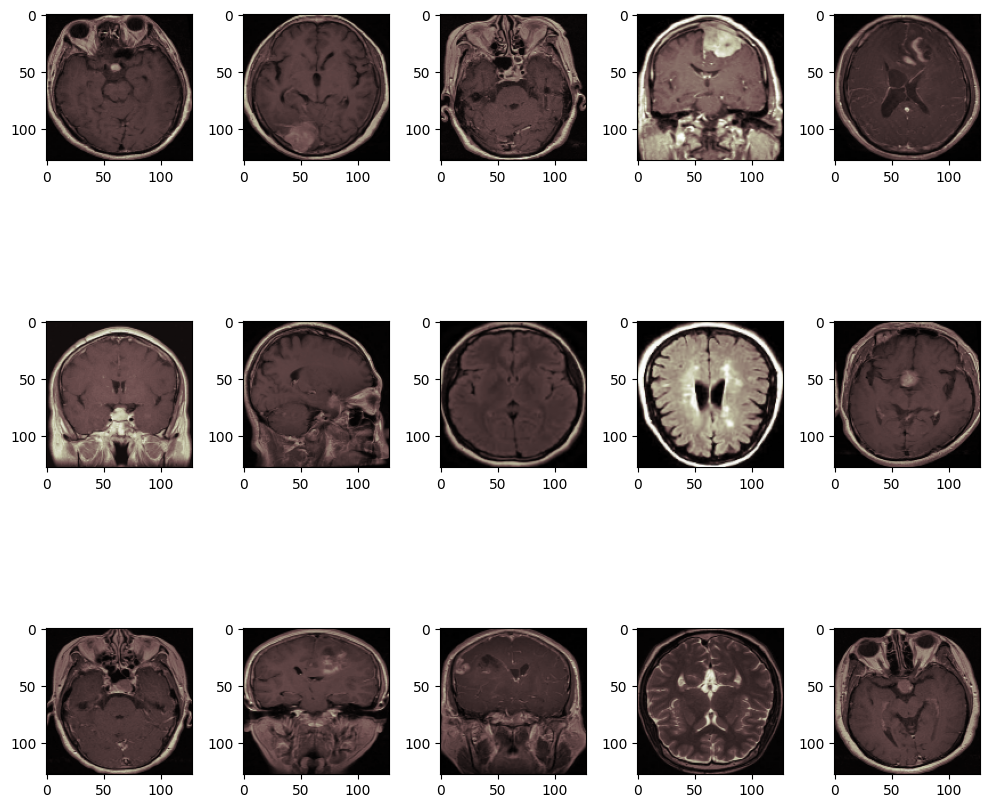

In [22]:
labels = ['glioma', 'meningioma', 'pituitary', 'notumor']
data_path = '/root/autodl-tmp/dataset/Br35H+SARTAJ+figshare/cropped'
image_size = 128
x_train, x_test, y_train, y_test = load_data(data_path, labels, image_size)

In [27]:
from tensorflow.keras.layers import ( Input, Conv2D, BatchNormalization, ReLU, MaxPooling2D, Concatenate, GlobalMaxPooling2D, Dropout,
    Dense, Lambda, Reshape, Activation, Multiply, Add, UpSampling2D )
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K


def load_model():


    net = VGG19(weights=None, include_top=False, input_shape=(128, 128, 3))
    x = net.output

    a = UpSampling2D(size=(6, 6))(x)
    a = MaxPooling2D(pool_size=(6, 6))(a)
    a = Conv2D(128, 1, padding='same')(a)

    b = UpSampling2D(size=(4, 4))(x)
    b = MaxPooling2D(pool_size=(4, 4))(b)
    b = Conv2D(128, 1, padding='same')(b)

    c = UpSampling2D(size=(3, 3))(x)
    c = MaxPooling2D(pool_size=(3, 3))(c)
    c = Conv2D(128, 1, padding='same')(c)

    d = UpSampling2D(size=(2, 2))(x)
    d = MaxPooling2D(pool_size=(2, 2))(d)
    d = Conv2D(128, 1, padding='same')(d)

    x =  Concatenate()([a, b, c, d])
    x = Conv2D(256, 1, padding='same')(x)
    x = Conv2D(128, 1, padding='same')(x)
    
    x = GlobalAveragePooling2D()(x)
    x = Dense(4, activation='softmax')(x)
    model = Model(inputs=net.input, outputs=x)
    
    return model



Epoch 1/50
115/143 [=======================>......] - ETA: 0s - loss: 1.3833 - accuracy: 0.2727

143/143 [==============================] - ETA: 0s - loss: 1.3795 - accuracy: 0.2737
Epoch 1: saving model to model-VGG16.h5
Epoch 1: 6.26 seconds
143/143 [==============================] - 6s 38ms/step - loss: 1.3795 - accuracy: 0.2737 - val_loss: 1.2805 - val_accuracy: 0.2797 - lr: 1.0000e-04
Epoch 2/50
143/143 [==============================] - ETA: 0s - loss: 1.1359 - accuracy: 0.4381
Epoch 2: saving model to model-VGG16.h5
Epoch 2: 5.31 seconds
143/143 [==============================] - 5s 37ms/step - loss: 1.1359 - accuracy: 0.4381 - val_loss: 1.1334 - val_accuracy: 0.4213 - lr: 1.0000e-04
Epoch 3/50
143/143 [==============================] - ETA: 0s - loss: 0.9943 - accuracy: 0.5160
Epoch 3: saving model to model-VGG16.h5
Epoch 3: 5.28 seconds
143/143 [==============================] - 5s 37ms/step - loss: 0.9943 - accuracy: 0.5160 - val_loss: 0.9624 - val_accuracy: 0.5857 - lr: 1.0000e-04
Epoch 4/50
143/143 [==============================] - ETA: 0s - loss: 0.9302 - accuracy: 0

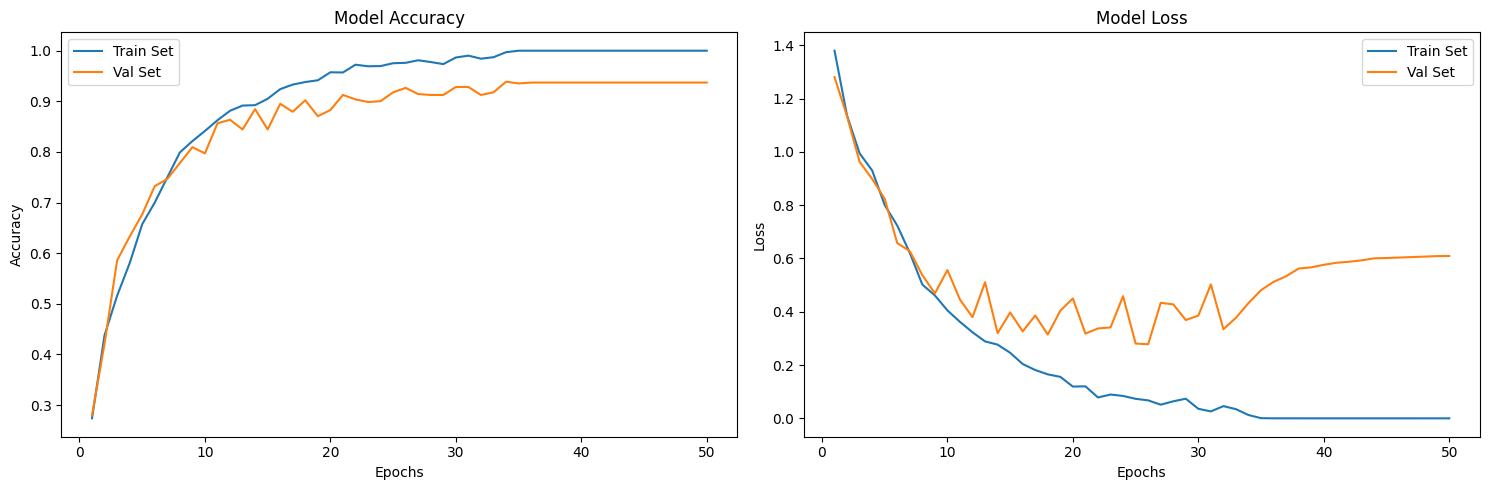

41/41 [==============================] - 0s 11ms/step - loss: 0.4180 - accuracy: 0.9512
Test Accuracy:  95.12
              precision    recall  f1-score   support

      glioma     0.9610    0.9033    0.9313       300
  meningioma     0.9150    0.9150    0.9150       306
   pituitary     0.9423    0.9800    0.9608       300
     notumor     0.9781    0.9926    0.9853       405

    accuracy                         0.9512      1311
   macro avg     0.9491    0.9477    0.9481      1311
weighted avg     0.9513    0.9512    0.9509      1311



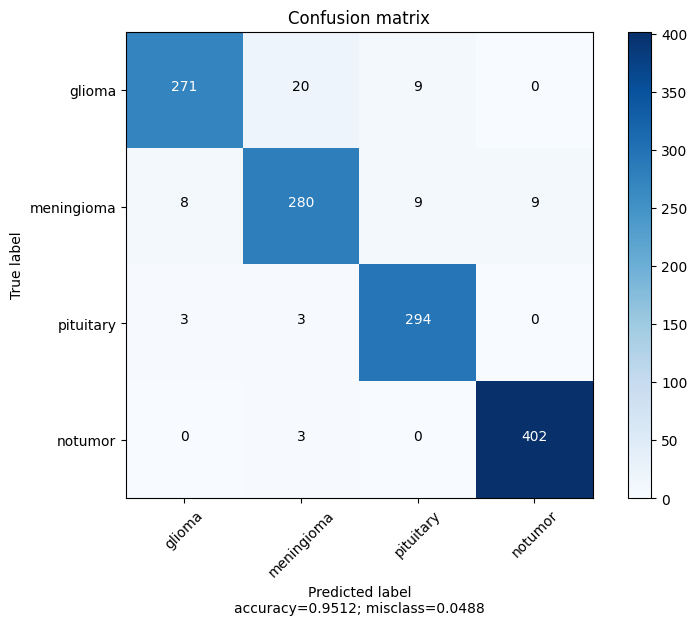

In [28]:
model = load_model()
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='NeuroNet19.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])

draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

## WeightedEM

100%|██████████| 405/405 [00:00<00:00, 521.11it/s]


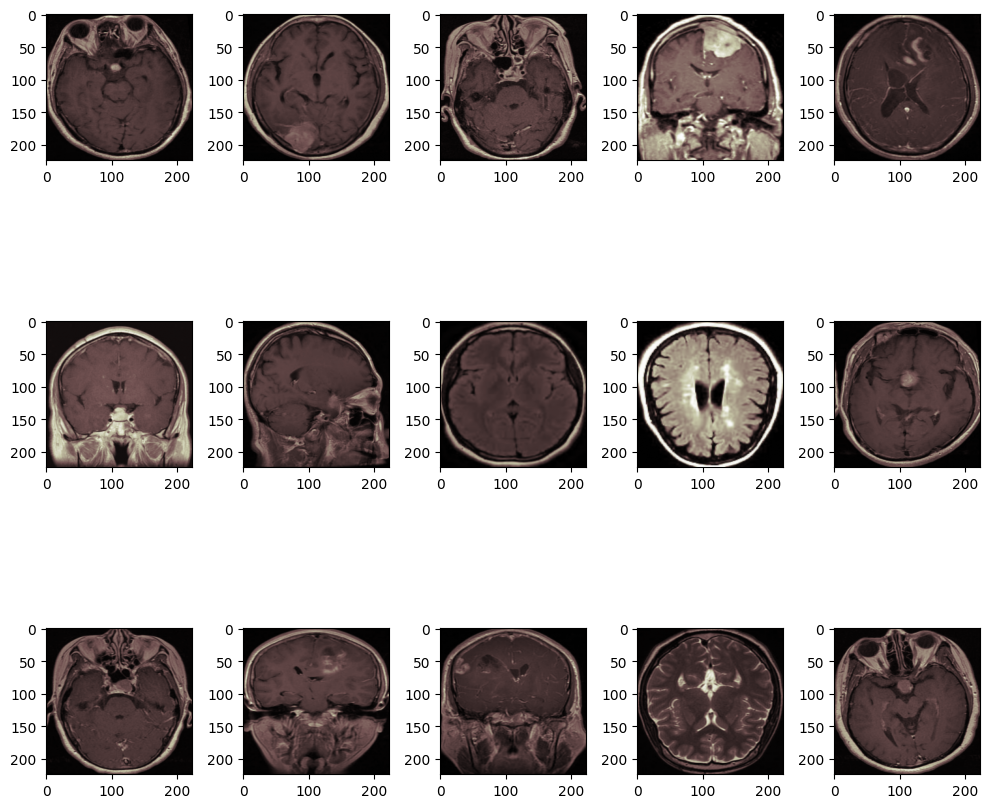

In [3]:
labels = ['glioma', 'meningioma', 'pituitary', 'notumor']
data_path = '/root/autodl-tmp/dataset/Br35H+SARTAJ+figshare/cropped'
image_size = 224
x_train, x_test, y_train, y_test = load_data(data_path, labels, image_size)

In [6]:
def CNN(inputs):
    
    x = Conv2D(32, 3, strides=4, padding='same')(inputs)
    x = ReLU()(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.1)(x)

    x = Conv2D(64, 3, strides=4, padding='same')(inputs)
    x = ReLU()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(128, 3, strides=4, padding='same')(inputs)
    x = ReLU()(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.1)(x)

    x = Conv2D(256, 3, strides=4, padding='same')(inputs)
    x = ReLU()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(512, 3, strides=4, padding='same')(inputs)
    x = ReLU()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)


    return x


def load_model():
    K.clear_session()
    inputs = Input(shape=(224, 224, 3))

    net = VGG19(weights=None, include_top=False, input_shape=(224, 224, 3))
    x = net.output
    x = GlobalAveragePooling2D()(x)
    x = x * 0.3

    y = CNN(net.input)
    y = GlobalAveragePooling2D()(y)
    y = y * 0.4

    z = CNN(net.input)
    z = GlobalAveragePooling2D()(z)
    z = z * 0.4

    k = Add()([x, y, z])
    
    k = Dropout(0.5)(k)
    k = Dense(4, activation='softmax')(k)
    model = Model(inputs= net.input, outputs=k)
    
    return model


Epoch 1/50
143/143 [==============================] - ETA: 0s - loss: 1.3663 - accuracy: 0.2821
Epoch 1: saving model to model-VGG16.h5
Epoch 1: 16.89 seconds
143/143 [==============================] - 17s 113ms/step - loss: 1.3663 - accuracy: 0.2821 - val_loss: 1.3650 - val_accuracy: 0.2797 - lr: 1.0000e-04
Epoch 2/50
143/143 [==============================] - ETA: 0s - loss: 1.2903 - accuracy: 0.3346
Epoch 2: saving model to model-VGG16.h5
Epoch 2: 15.79 seconds
143/143 [==============================] - 16s 110ms/step - loss: 1.2903 - accuracy: 0.3346 - val_loss: 1.1312 - val_accuracy: 0.5140 - lr: 1.0000e-04
Epoch 3/50
143/143 [==============================] - ETA: 0s - loss: 1.0505 - accuracy: 0.5152
Epoch 3: saving model to model-VGG16.h5
Epoch 3: 15.76 seconds
143/143 [==============================] - 16s 110ms/step - loss: 1.0505 - accuracy: 0.5152 - val_loss: 0.9999 - val_accuracy: 0.5717 - lr: 1.0000e-04
Epoch 4/50
143/143 [==============================] - ETA: 0s - loss: 

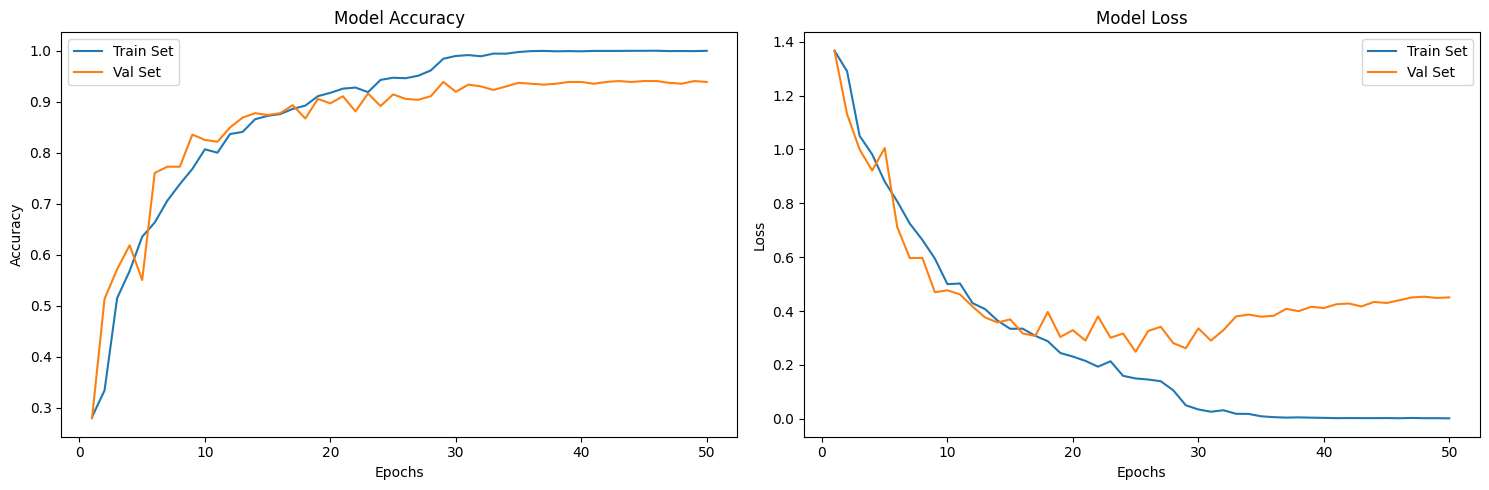

41/41 [==============================] - 1s 34ms/step - loss: 0.2718 - accuracy: 0.9443
Test Accuracy:  94.43
              precision    recall  f1-score   support

      glioma     0.9552    0.8533    0.9014       300
  meningioma     0.8834    0.9412    0.9114       306
   pituitary     0.9416    0.9667    0.9539       300
     notumor     0.9878    0.9975    0.9926       405

    accuracy                         0.9443      1311
   macro avg     0.9420    0.9397    0.9398      1311
weighted avg     0.9454    0.9443    0.9439      1311



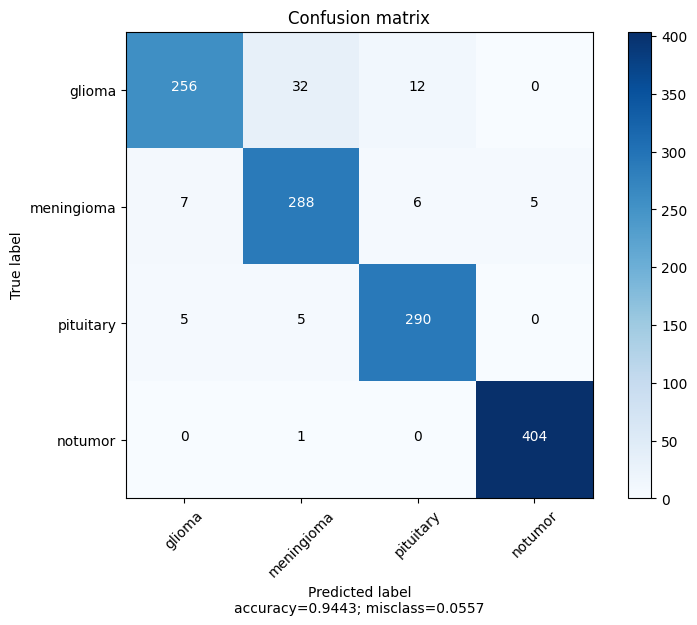

In [7]:
model = load_model()
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='WeightedEM.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])

draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

## DNNwithSVM

100%|██████████| 405/405 [00:00<00:00, 517.16it/s]


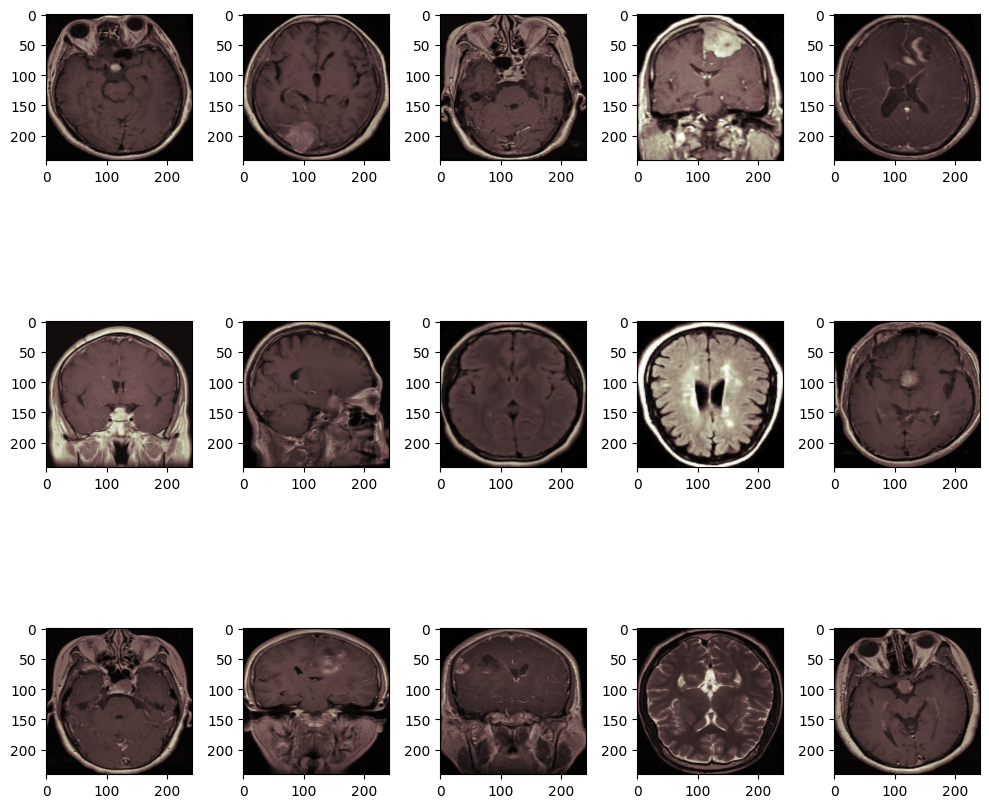

In [8]:
labels = ['glioma', 'meningioma', 'pituitary', 'notumor']
data_path = '/root/autodl-tmp/dataset/Br35H+SARTAJ+figshare/cropped'
image_size = 241
x_train, x_test, y_train, y_test = load_data(data_path, labels, image_size)

In [9]:
def load_model():
    K.clear_session()
    inputs = Input(shape=(241, 241, 3))

    x = Conv2D(96, 9, strides=4, padding='valid')(inputs)
    x = ReLU()(x)
    x = LayerNormalization()(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid')(x)

    x = Conv2D(256, 7, strides=1, padding='same')(x)
    x = ReLU()(x)
    x = LayerNormalization()(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid')(x)

    x = Conv2D(384, 3, strides=1, padding='same')(x)
    x = ReLU()(x)

    x = Conv2D(384, 3, strides=1, padding='same')(x)
    x = ReLU()(x)

    x = Conv2D(256, 3, strides=1, padding='same')(x)
    x = ReLU()(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid')(x)

    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(4, activation='softmax')(x)
    model = Model(inputs= inputs, outputs=x)
    
    return model


Epoch 1/50
143/143 [==============================] - ETA: 0s - loss: 1.2097 - accuracy: 0.4249
Epoch 1: saving model to model-VGG16.h5
Epoch 1: 3.71 seconds
143/143 [==============================] - 4s 20ms/step - loss: 1.2097 - accuracy: 0.4249 - val_loss: 0.9785 - val_accuracy: 0.5262 - lr: 1.0000e-04
Epoch 2/50
141/143 [============================>.] - ETA: 0s - loss: 0.9687 - accuracy: 0.5638
Epoch 2: saving model to model-VGG16.h5
Epoch 2: 2.27 seconds
143/143 [==============================] - 2s 16ms/step - loss: 0.9675 - accuracy: 0.5652 - val_loss: 0.9975 - val_accuracy: 0.5909 - lr: 1.0000e-04
Epoch 3/50
141/143 [============================>.] - ETA: 0s - loss: 0.8007 - accuracy: 0.6495
Epoch 3: saving model to model-VGG16.h5
Epoch 3: 2.30 seconds
143/143 [==============================] - 2s 16ms/step - loss: 0.7978 - accuracy: 0.6510 - val_loss: 0.6478 - val_accuracy: 0.7343 - lr: 1.0000e-04
Epoch 4/50
141/143 [============================>.] - ETA: 0s - loss: 0.6208 - 

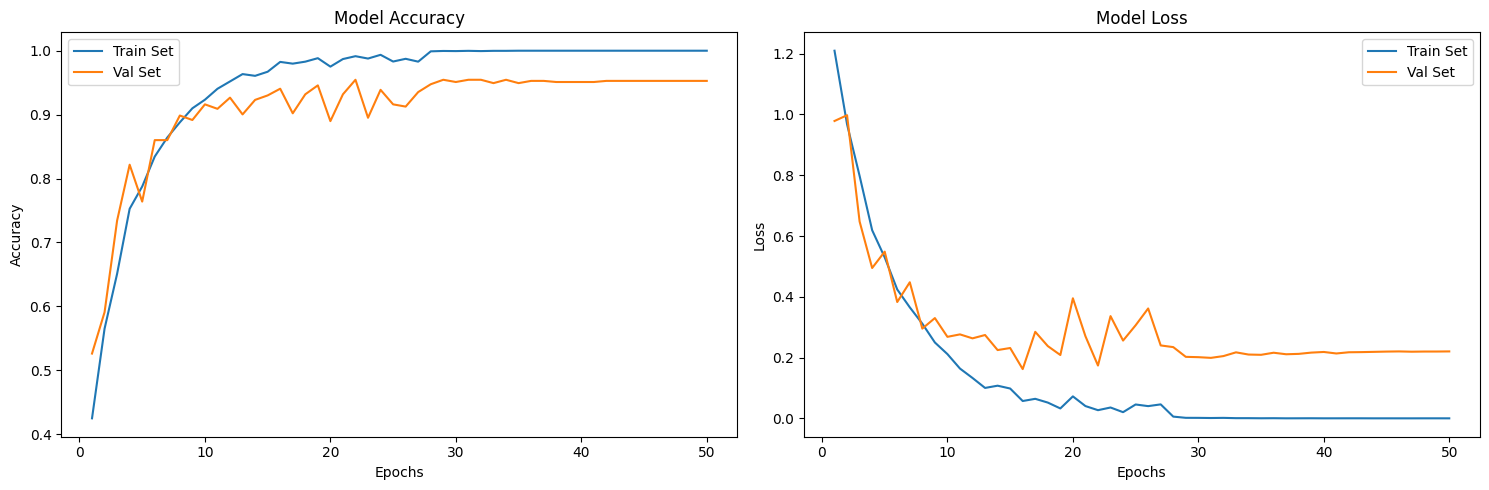

41/41 [==============================] - 0s 7ms/step - loss: 0.1391 - accuracy: 0.9672
Test Accuracy:  96.72
              precision    recall  f1-score   support

      glioma     0.9789    0.9267    0.9521       300
  meningioma     0.9236    0.9477    0.9355       306
   pituitary     0.9769    0.9867    0.9818       300
     notumor     0.9854    0.9975    0.9914       405

    accuracy                         0.9672      1311
   macro avg     0.9662    0.9646    0.9652      1311
weighted avg     0.9675    0.9672    0.9671      1311



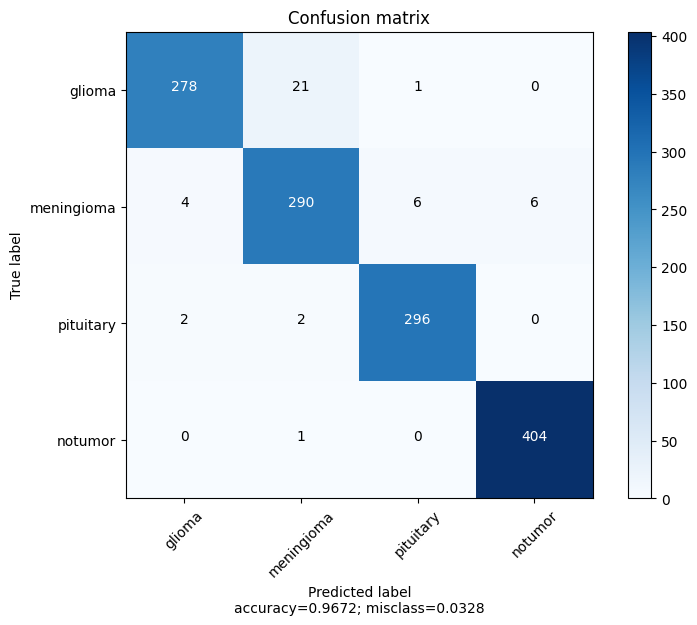

In [10]:
model = load_model()
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='DNNwithSVM.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])

draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

## VGG19-TLFT

![](VGG19TLFT.png)